In [1]:
import io
import os
import sys
import csv
import gzip
import time
import json
import secrets
import pickle
import multiprocessing
import subprocess
import resource
import itertools
import collections
import sqlite3
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import random
from collections import Counter
from collections import defaultdict
import copy
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D

from scipy.stats import nbinom, norm, geom, beta, poisson
from scipy.special import logsumexp

sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
sys.path.append('/Users/sus_zhang/Desktop/Suuuuuuuus/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *

sys.path.append('/well/band/users/rbx225/GAMCC/scripts/lcSV/')
sys.path.append('/Users/sus_zhang/Desktop/Suuuuuuuus/Low Coverage Data/gamcc/scripts/lcSV/')
from lcSV import *

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

/gpfs3/well/band/users/rbx225/GAMCC


<Figure size 100x100 with 0 Axes>

# Calling sex lcWGS

      sample    chrX    chrY sex
72   IDT0735  0.6028  0.4858   F
118  IDT0549  0.5612  0.4986   F
160  IDT0498  0.5774  0.4674   F


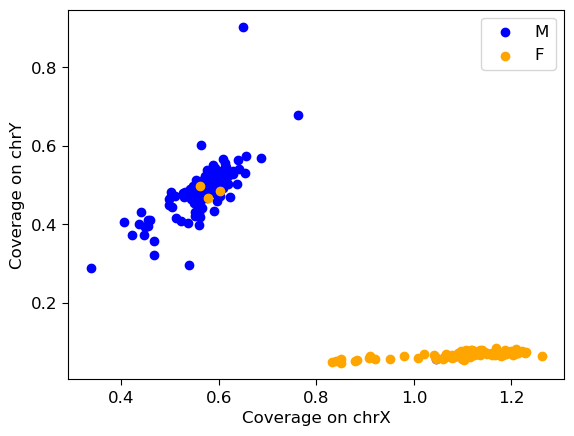

In [2]:
indir = 'results/coverage/sex/'
samples = lcwgsus.read_tsv_as_lst('data/sample_tsvs/fv_idt_names.tsv')

df_lst = []
for i in samples:
    df = pd.read_csv(f'{indir}{i}.sexchr.tsv', sep = '\t', header = None) 
    df.columns = ['sample', 'chrX', 'chrY']
    df_lst.append(df)
df = pd.concat(df_lst).reset_index(drop = True)

metadata = pd.read_csv('data/metadata/sex.csv')
sl = pd.read_csv(SAMPLE_LINKER_FILE)
sl = sl[~sl['Sample_Name'].str.contains('mini')]

metadata = metadata[metadata['GMID'].isin(sl['Sample_Name'])]
sl = {k:v for k, v in zip(sl['Sample_Name'], sl['Seq_Name'])}
metadata['GMID'] = metadata['GMID'].apply(lambda x: sl[x])
metadata.columns = ['sample', 'sex']
df = pd.merge(df, metadata, on = 'sample')

labels = ['M', 'F']
colors = ['blue', 'orange']
for i, s in enumerate(labels):
    tmp = df[df['sex'] == s]
    if s == 'F':
        print(tmp[tmp['chrY'] > 0.2])
    plt.scatter(tmp['chrX'], tmp['chrY'], color = colors[i], label = s)
plt.xlabel('Coverage on chrX')
plt.ylabel('Coverage on chrY')
plt.legend()

# Coverage at specific regions

In [49]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

## GYP region

### DEL1

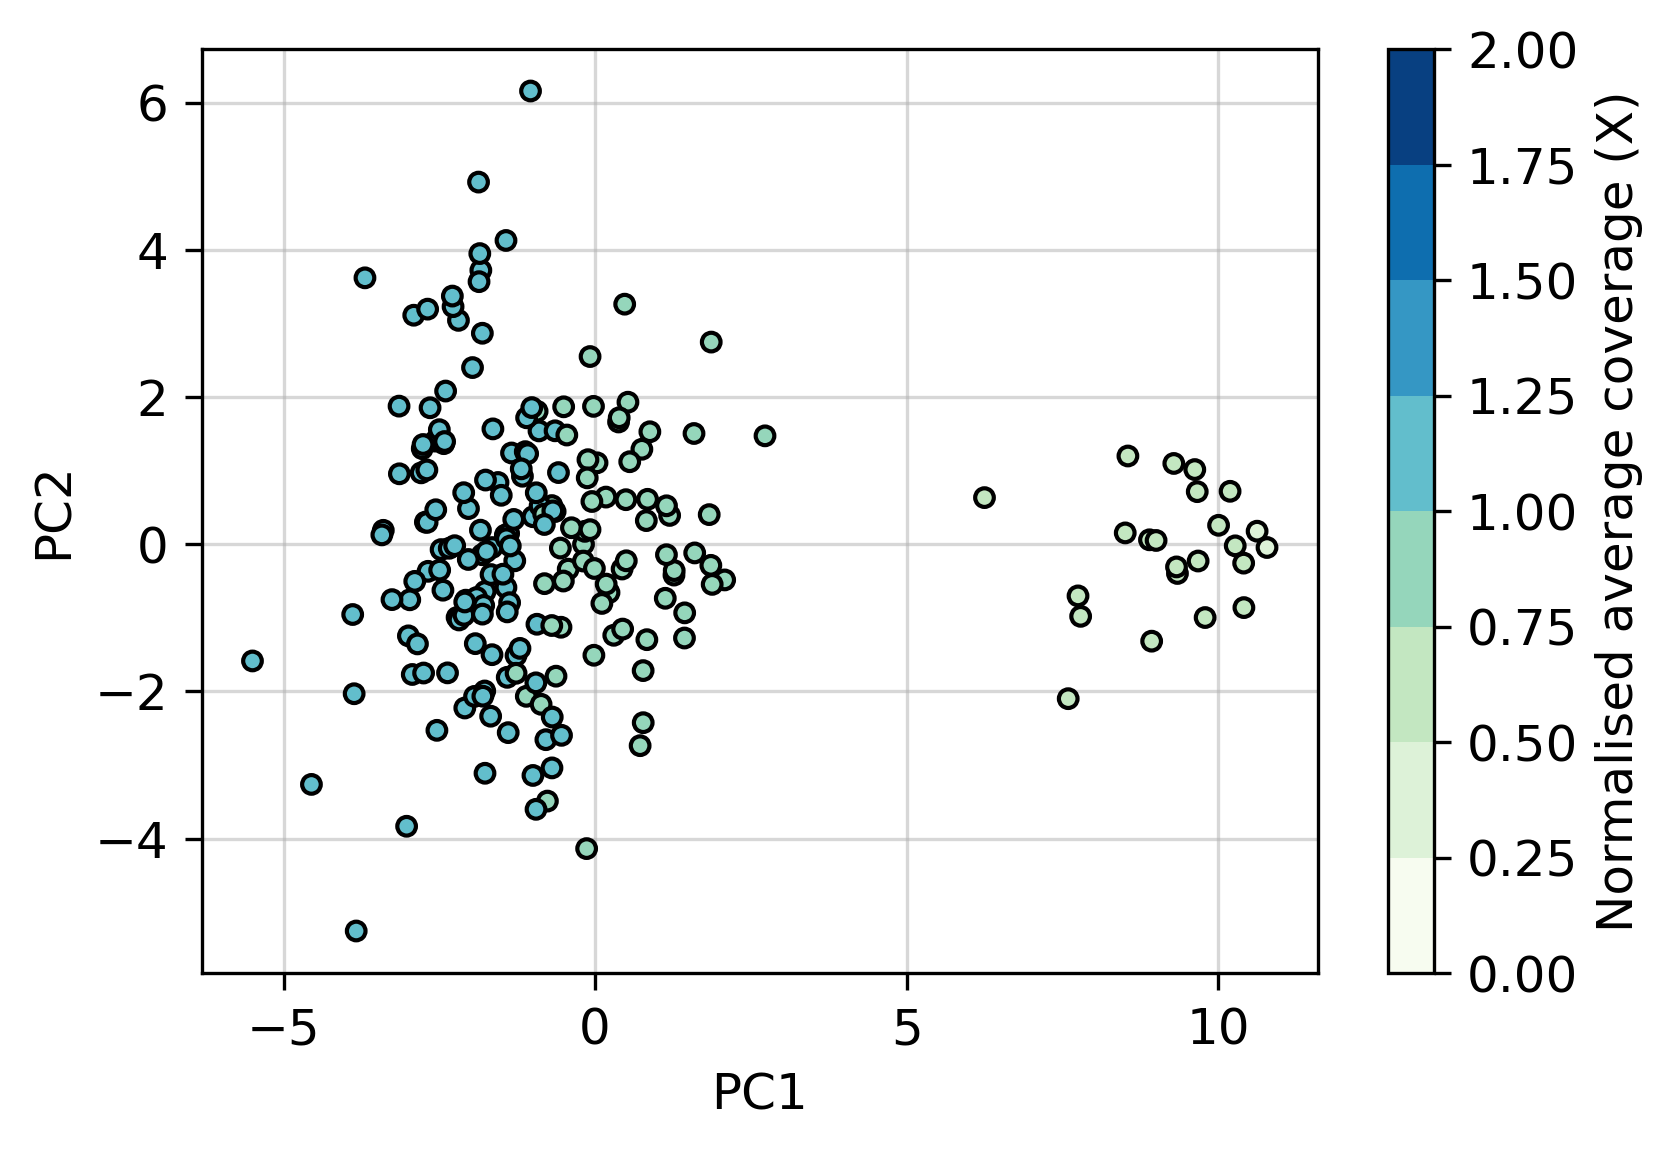

In [93]:
binsize = 1000
chromosome = 4
d1_start = 143910000
d1_end = 144030000
flank = d1_end - d1_start

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]
pc_df['cov'] = avg_coverage

fig = plt.figure(figsize=(6, 4), dpi = 300)

im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = pc_df['cov'],
                     cmap='GnBu', norm=norm, edgecolor='black', s = 20, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Text(0, 0.5, 'Coverage (X)')

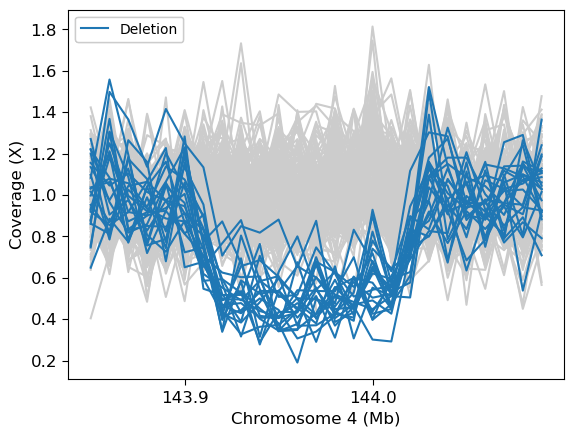

In [91]:
new_window = 10000
tick_step = 0.1
    
cov1 = deresolute_windows(cov, new_window, normalise = True)
del1_region = normalise_by_flank(cov1, d1_start, d1_end, flank)

e1 = flank/2
fstart = (d1_start-e1)
fend = (d1_end+e1)

del1_region = del1_region[(del1_region['position'] >= fstart) & (del1_region['position'] <= fend)]
del1_region['position'] = del1_region['position']/1000000

del1 = pc_df[pc_df['PC1'] < 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = '0.8')

c = plt.get_cmap(CATEGORY_CMAP_STR).colors[:1][0]
c = mcolors.to_hex(c)

del1 = pc_df[pc_df['PC1'] > 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = c)
    
ticks = get_ticks(del1_region, tick_step)
plt.xticks(ticks, [f"{tick:.{int(np.log10(1/tick_step))}f}" for tick in ticks])

color_handles = [
    Line2D([0], [0], color=c, label='Deletion')
]

legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
legend1.get_title().set_fontsize(9)
plt.gca().add_artist(legend1)

plt.xlabel('Chromosome 4 (Mb)')
plt.ylabel('Coverage (X)')

### DEL1 by Ethnicities

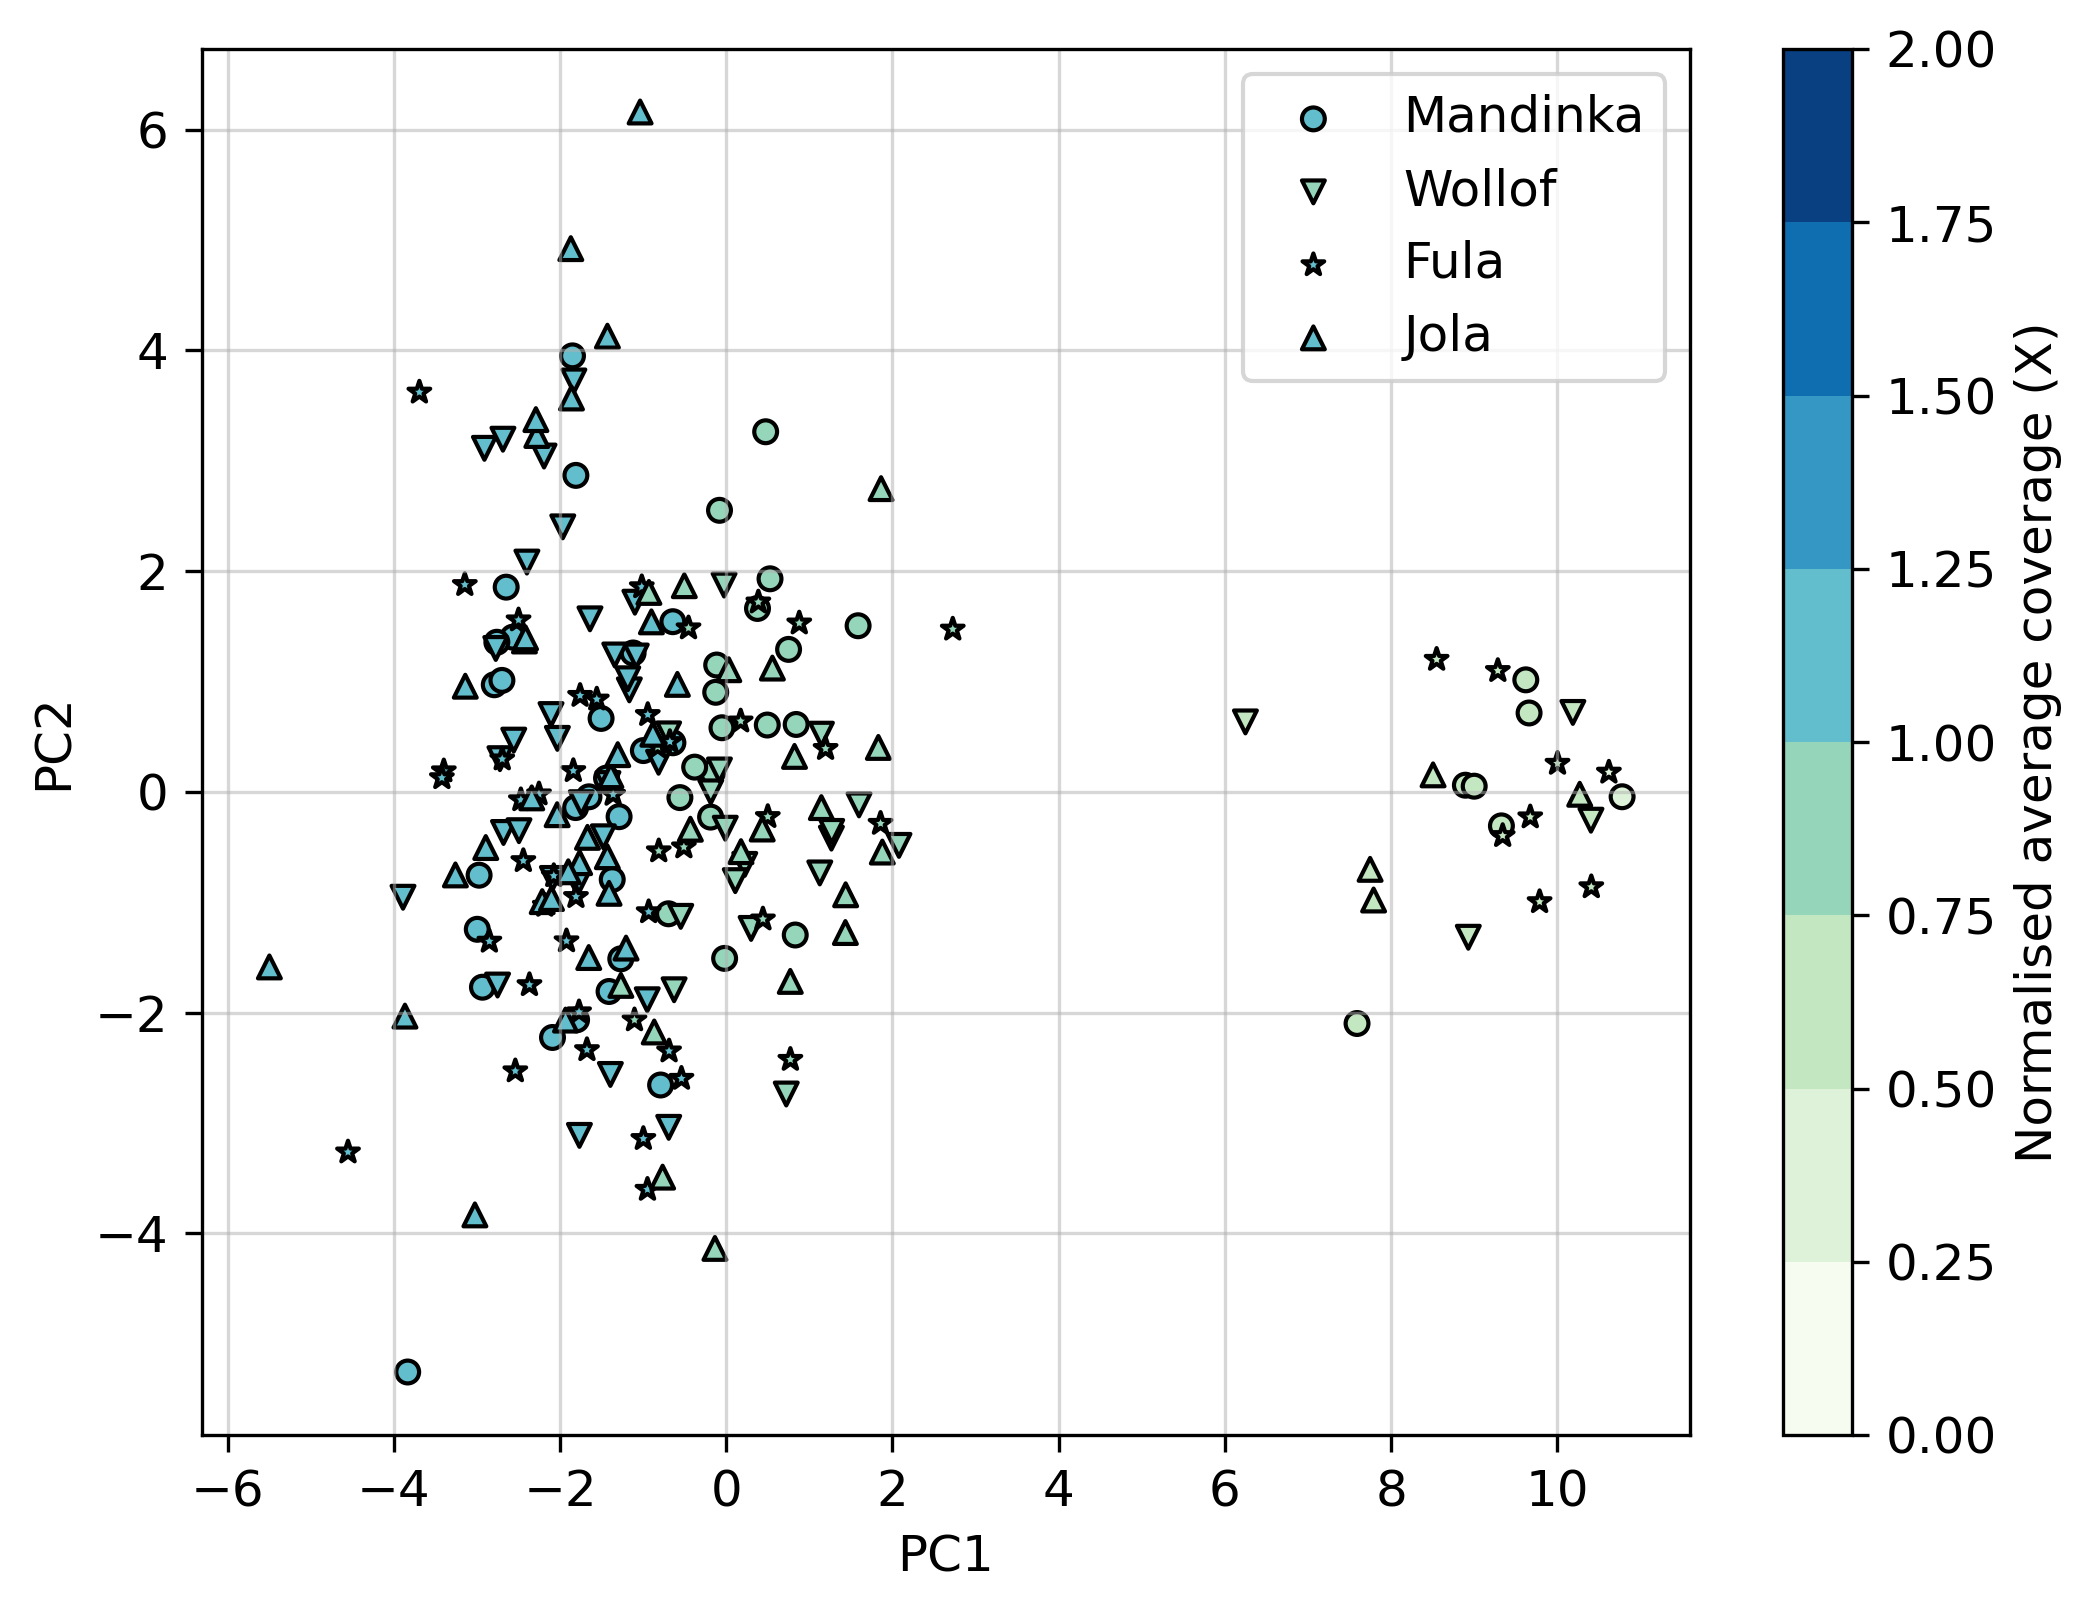

In [28]:
eth = pd.read_csv('data/metadata/ethnic_group.csv')
sl = pd.read_csv(SAMPLE_LINKER_FILE)
sl = sl[~sl['Sample_Name'].str.contains('mini')]

eth = eth[eth['Chip_Name'].isin(sl['Chip_Name'])]
sl = {k:v for k, v in zip(sl['Chip_Name'], sl['Seq_Name'])}
eth['Chip_Name'] = eth['Chip_Name'].apply(lambda x: sl[x])
eth = eth.sort_values(by = 'Chip_Name').reset_index(drop = True)
ethnicities = eth['ethnic'].unique().tolist()

flank_cov = cov[((cov['position'] >= d1_start - flank) & (cov['position'] < d1_start)) | 
    ((cov['position'] > d1_end) & (cov['position'] <= d1_end+flank))].mean(axis = 0).iloc[1:]

cov1 = cov.copy()
for i, s in enumerate(cov1.columns[1:]):
    cov1[s] = cov1[s]/(flank_cov.loc[s])

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]
pc_df['ethnic'] = eth['ethnic']
pc_df['cov'] = avg_coverage

markers = ['o', 'v', '*', '^']

fig = plt.figure(figsize=(8, 6), dpi = 300)
for i, e in enumerate(ethnicities):
    tmp = pc_df[pc_df['ethnic'] == e]
    im = plt.scatter(tmp['PC1'], tmp['PC2'], c = tmp['cov'], marker = markers[i], 
                     cmap='GnBu', norm=norm, edgecolor='black', s = 30, label = e)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5)

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### DEL2

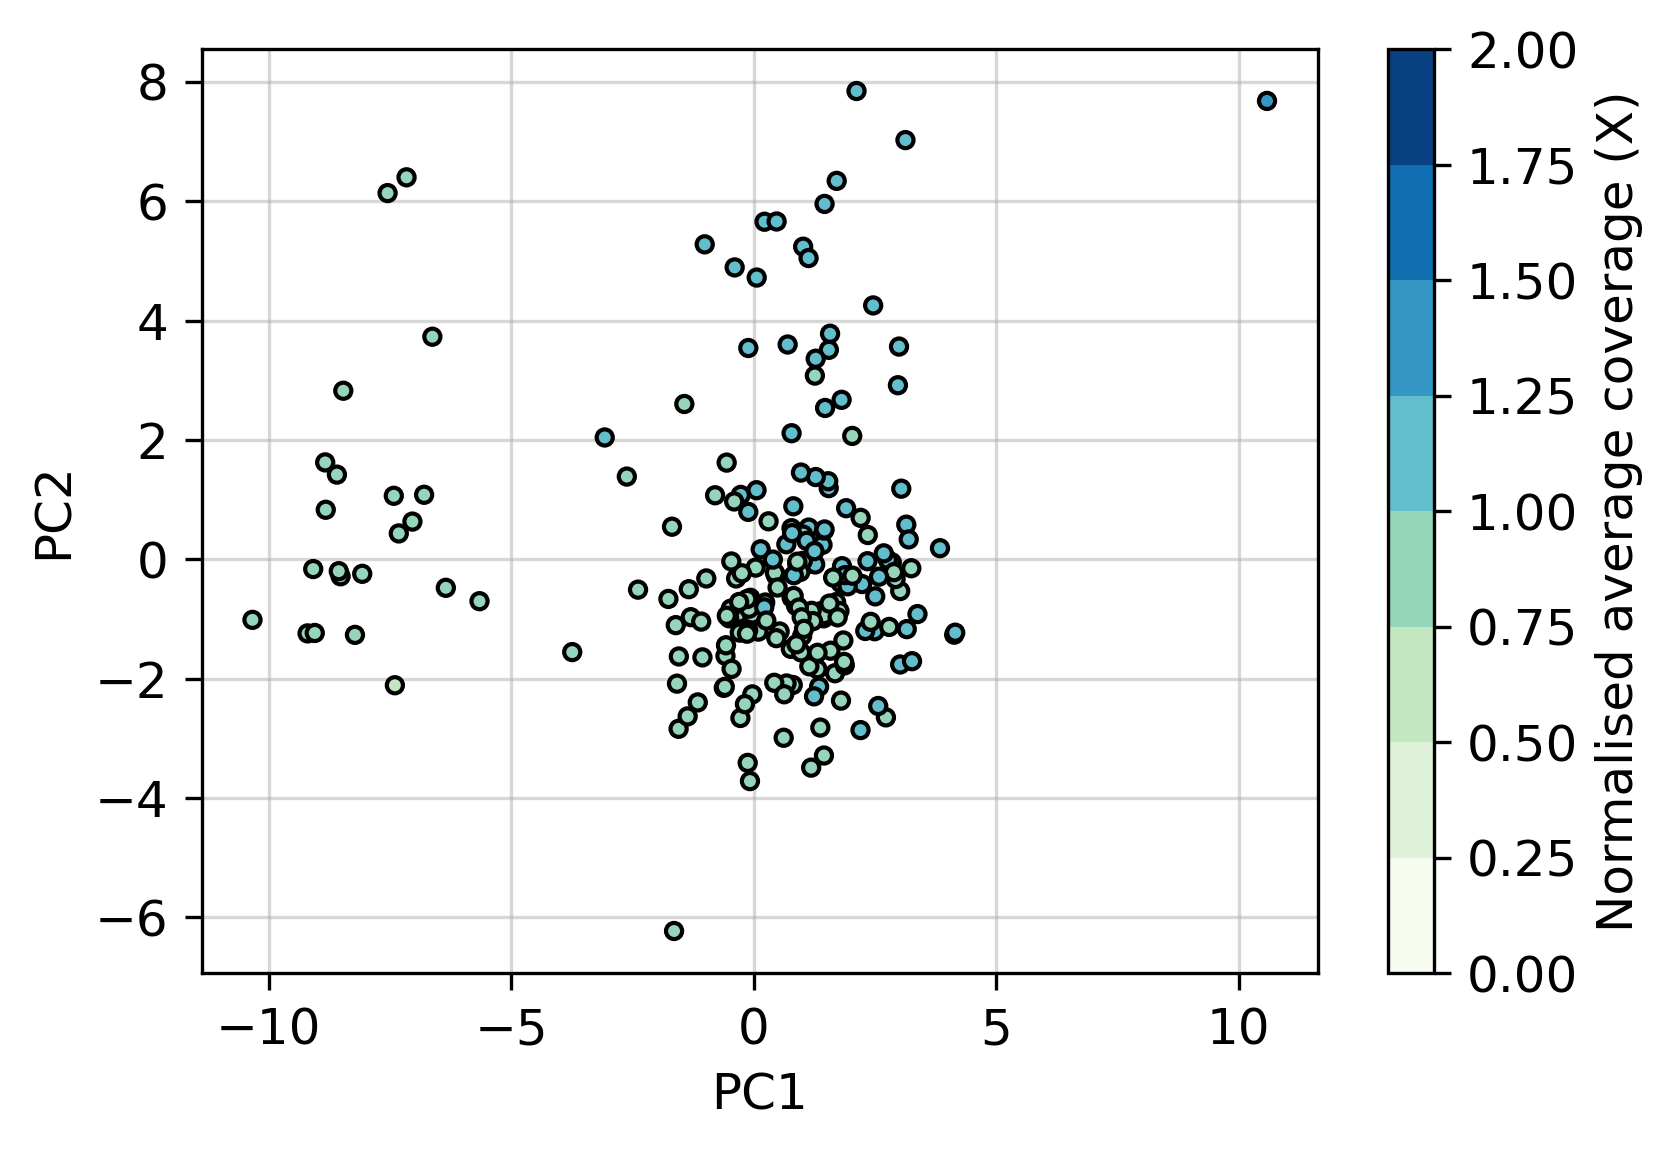

In [172]:
binsize = 1000
chromosome = 4
d1_start = 143780000
d1_end = 143780000 + 210000
flank = d1_end - d1_start
e1 = flank/2

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]


fig = plt.figure(figsize=(6, 4), dpi = 300)
# ax = fig.gca()
im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = avg_coverage, cmap='GnBu', norm = norm, edgecolor='black', s = 15, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### DUP1

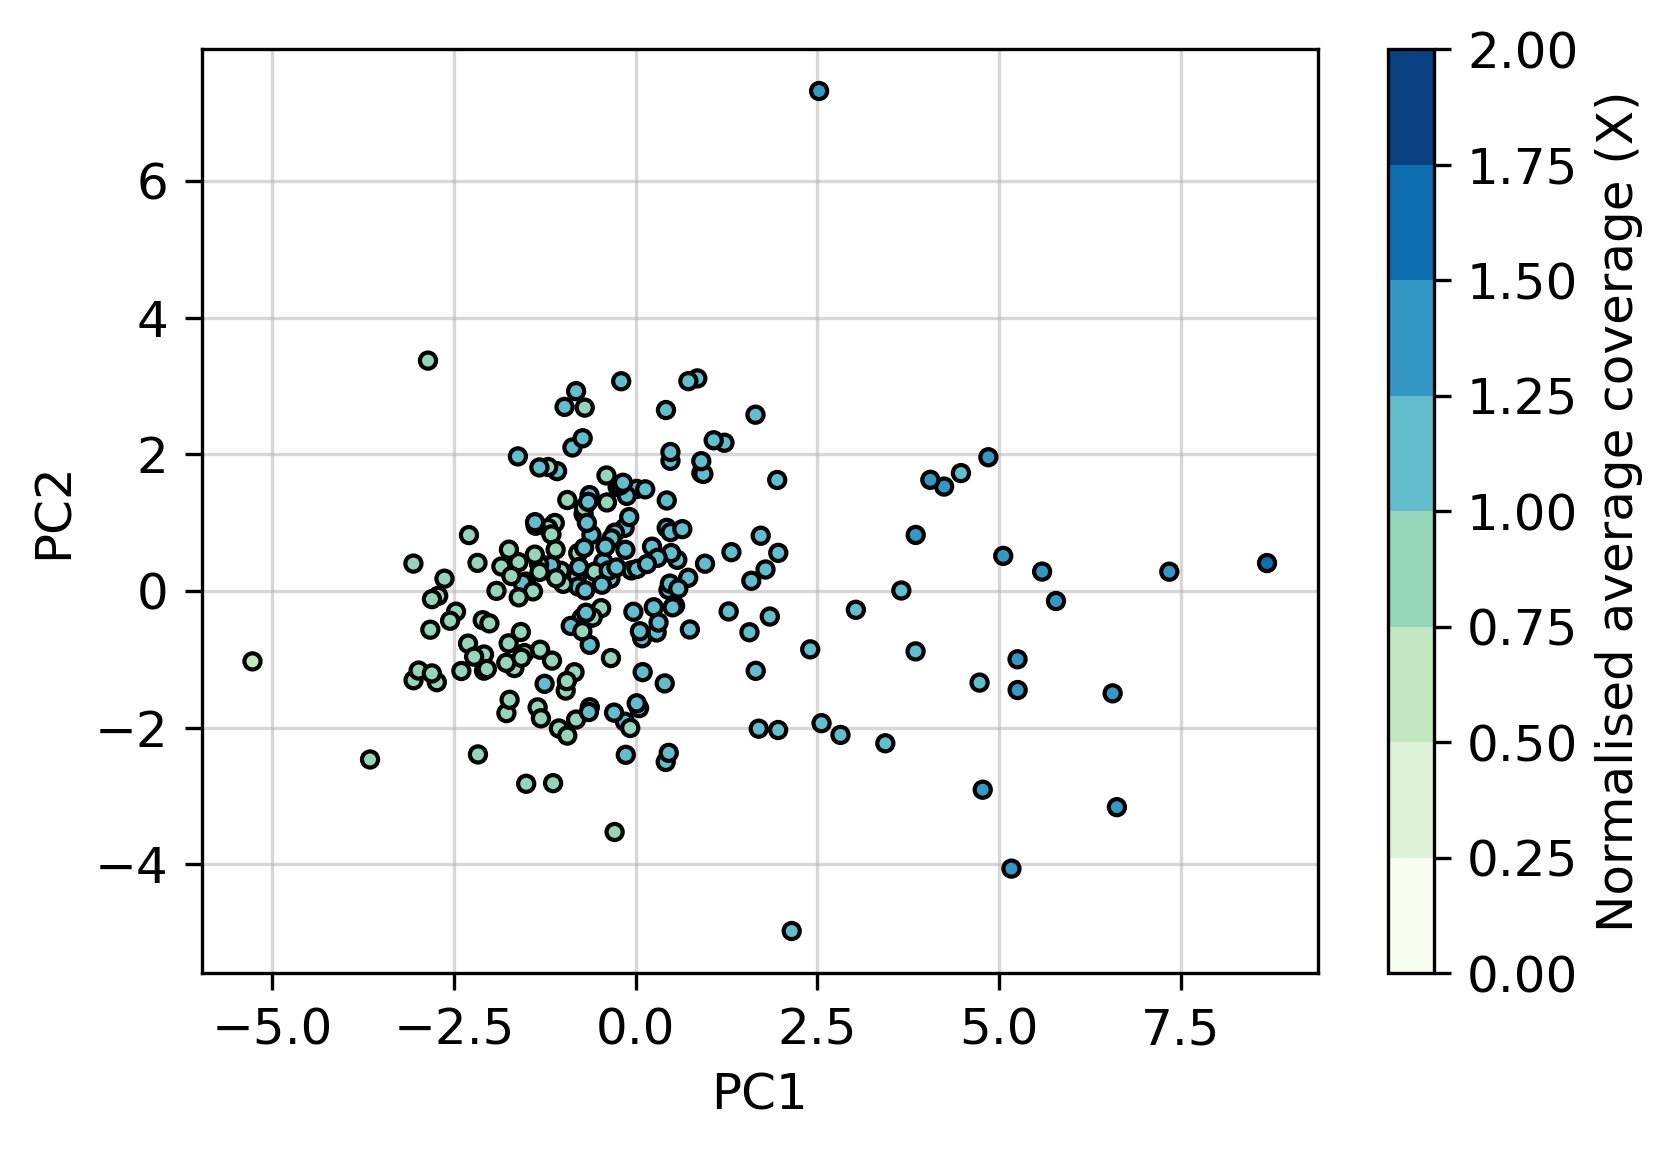

In [50]:
binsize = 1000
chromosome = 4
d1_start = 143790000
d1_end = 143850000
# d1_start = 143778847
# d1_end = 143878847
flank = d1_end - d1_start
e1 = flank/2

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]

fig = plt.figure(figsize=(6, 4), dpi = 300)
# ax = fig.gca()
im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = avg_coverage, cmap='GnBu', norm = norm, edgecolor='black', s = 15, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Text(0, 0.5, 'Coverage (X)')

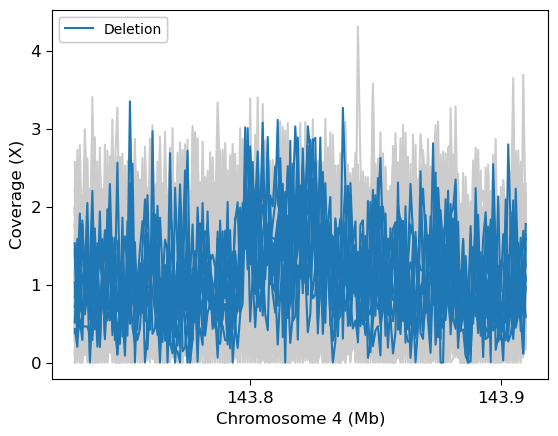

In [51]:
# new_window = 10000
# cov1 = deresolute_windows(cov, new_window, normalise = True)
cov1 = cov.copy()
tick_step = 0.1
e1 = flank/2
fstart = (d1_start-e1)
fend = (d1_end+e1)

del1_region = normalise_by_flank(cov1, d1_start, d1_end, flank)
del1_region = del1_region[(del1_region['position'] >= d1_start - flank) & (del1_region['position'] <= d1_end + flank)]
del1_region['position'] = del1_region['position']/1000000

del1 = pc_df[pc_df['PC1'] < 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = '0.8')

c = plt.get_cmap(CATEGORY_CMAP_STR).colors[:1][0]
c = mcolors.to_hex(c)

del1 = pc_df[pc_df['PC1'] > 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = c)

ticks = get_ticks(del1_region, tick_step)
plt.xticks(ticks, [f"{tick:.{int(np.log10(1/tick_step))}f}" for tick in ticks])

color_handles = [
    Line2D([0], [0], color=c, label='Deletion')
]

legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
legend1.get_title().set_fontsize(9)
plt.gca().add_artist(legend1)

plt.xlabel('Chromosome 4 (Mb)')
plt.ylabel('Coverage (X)')

## HBA region

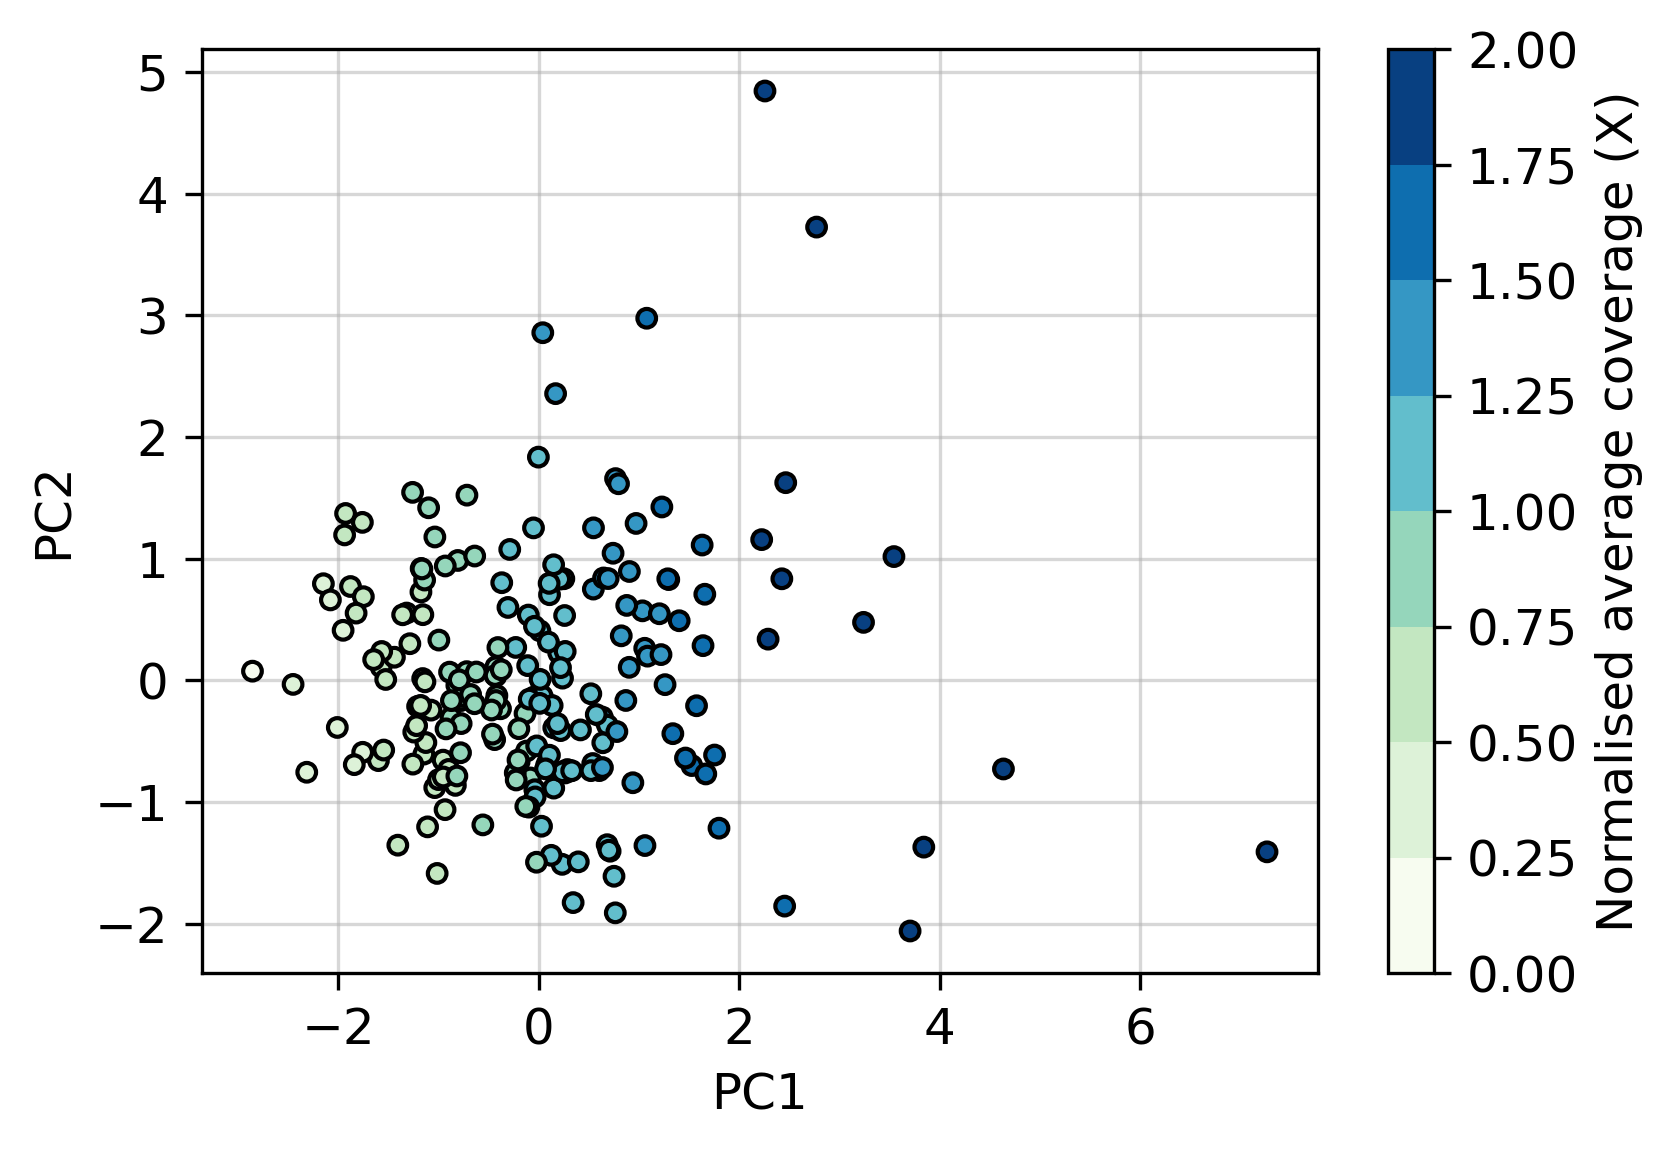

In [67]:
binsize = 300
chromosome = 16
d1_start = 173598
d1_end = 177378
flank = d1_end - d1_start
e1 = flank/2

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
# cov = pd.read_csv('results/coverage/specific_regions/HBA.tsv', sep = '\t')
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]
pc_df['cov'] = avg_coverage

fig = plt.figure(figsize=(6, 4), dpi = 300)

im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = pc_df['cov'],
                     cmap='GnBu', norm=norm, edgecolor='black', s = 20, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Text(0, 0.5, 'Coverage (X)')

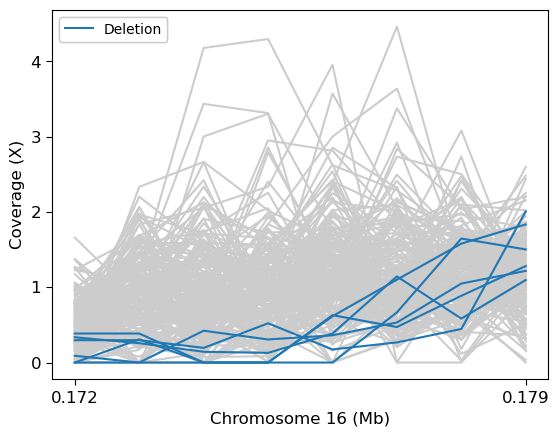

In [68]:
tick_step = 0.001
cutoff = -2

del1_region = cov1

e1 = flank/2
fstart = (d1_start-e1)
fend = (d1_end+e1)

del1_region = del1_region[(del1_region['position'] >= fstart) & (del1_region['position'] <= fend)]
del1_region['position'] = del1_region['position']/1000000

del1 = pc_df[pc_df['PC1'] >= cutoff]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = '0.8')

c = plt.get_cmap(CATEGORY_CMAP_STR).colors[:1][0]
c = mcolors.to_hex(c)

del1 = pc_df[pc_df['PC1'] < cutoff]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = c)

# ticks = get_ticks(del1_region, tick_step)
plt.xticks([del1_region.iloc[0,0], del1_region.iloc[-1,0]])

color_handles = [
    Line2D([0], [0], color=c, label='Deletion')
]

legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
legend1.get_title().set_fontsize(9)
plt.gca().add_artist(legend1)

plt.xlabel(f'Chromosome {chromosome} (Mb)')
plt.ylabel('Coverage (X)')

# Genome-wide Coverage

# Nonahore

## Generate simulate data

In [8]:
with open('results/nonahore/simulation_results.pickle', 'rb') as of:
    data = pickle.load(of)
    
N = 210
nb_vars = [100, 500, 1000, 2000]
Ls = [5, 10, 20, 30] # translate to 1k, 3k, 6.6k, 10k SVLEN
fs = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
replicates = 3

avgrep_eval_dict = {}
for v in nb_vars:
    for l in Ls:
        for f1 in fs: 
            reps = np.array([np.array(data[f'{v}-{l}-{f1}-{r}']) for r in range(replicates)])
            avgrep_eval_dict[f'{v}-{l}-{f1}'] = np.mean(reps, axis = 0)

avgrep_eval_dict

{'100-5-0.05': array([0., 0., 0.]),
 '100-5-0.1': array([0.33333333, 0.30710718, 0.03704059]),
 '100-5-0.15': array([0., 0., 0.]),
 '100-5-0.2': array([0., 0., 0.]),
 '100-5-0.25': array([0.33333333, 0.31294182, 0.07727229]),
 '100-5-0.3': array([0., 0., 0.]),
 '100-5-0.35': array([0., 0., 0.]),
 '100-5-0.4': array([0.66666667, 0.64420555, 0.28109068]),
 '100-5-0.45': array([0.33333333, 0.32353949, 0.14659622]),
 '100-5-0.5': array([0., 0., 0.]),
 '100-10-0.05': array([1.        , 0.95230488, 0.0437473 ]),
 '100-10-0.1': array([1.        , 0.97596891, 0.10627501]),
 '100-10-0.15': array([0.66666667, 0.64387009, 0.10604359]),
 '100-10-0.2': array([1.        , 0.98336381, 0.2086527 ]),
 '100-10-0.25': array([1.        , 0.98226215, 0.25294801]),
 '100-10-0.3': array([1.        , 0.98919239, 0.31409549]),
 '100-10-0.35': array([1.        , 0.98599646, 0.35384232]),
 '100-10-0.4': array([1.        , 0.99122151, 0.38989536]),
 '100-10-0.45': array([1.        , 0.98780794, 0.44472346]),
 '10

### Testing a single case

In [67]:
N = 210
nb_vars = 100
Ls = 10
fs = 0.05
replicates = 1
binsize = 1000

mean_coverage = 1.21
sd_coverage = 0.12

n_recomb = 200
n_iter = 500
verbose = False

h1 = np.ones(l)
h2 = h1.copy()
h2[int(l/3):int(2*l/3)] = 0
model = SVModel([h1,h2], [1-f1,f1])
training, coverage, true_gt = simulate_coverotron(model, N, l, mean_coverage, sd_coverage, v)

eval_dict = {}
means = np.mean(training, axis = 0)
variances = np.var(training, axis = 0, ddof = 1)
result_dict = nonahore(means, variances, coverage, n_recomb = n_recomb, n_iter = n_iter, verbose = verbose)
                
concordance, info, freq = evaluate_sim_model(result_dict, h2, true_gt)
concordance, info, freq

(1.0, 1.0, 0.14522695332433527)

### Measure empirical nbvar

(array([16., 32., 43., 47., 33., 23.,  7.,  2.,  4.,  3.]),
 array([ 4425.58099617,  6145.3217318 ,  7865.06246743,  9584.80320307,
        11304.5439387 , 13024.28467433, 14744.02540996, 16463.76614559,
        18183.50688123, 19903.24761686, 21622.98835249]),
 <BarContainer object of 10 artists>)

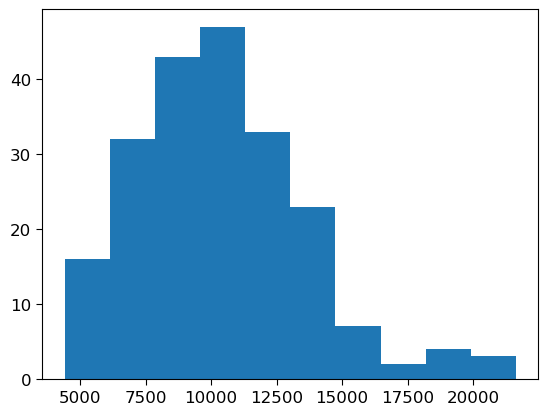

In [64]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000
chromosome = 16
start = 160000
end = 190000
flank = end - start

cov = load_region_files(regions, chromosome, start, end)
cov['position'] = cov['position'].astype(int)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
cov = cov[(cov['position'] >= start) & (cov['position'] < end)]
plt.hist(cov.iloc[:,1:-1].var(axis = 0)/len(cov))

(array([ 2., 12., 34., 44., 53., 30., 18.,  9.,  6.,  2.]),
 array([ 4703.6287288 ,  5743.63174434,  6783.63475989,  7823.63777544,
         8863.64079098,  9903.64380653, 10943.64682207, 11983.64983762,
        13023.65285317, 14063.65586871, 15103.65888426]),
 <BarContainer object of 10 artists>)

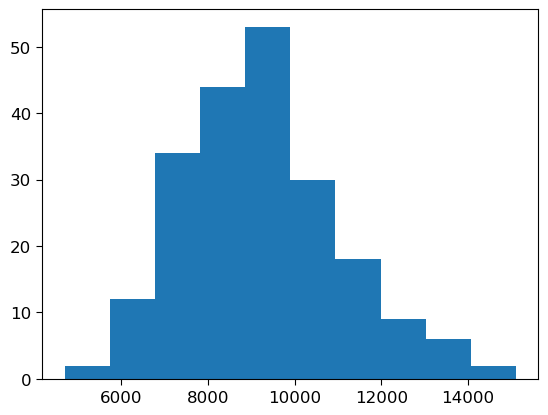

In [66]:
model = best_model

_,c,_ = simulate_coverotron(model, 210, len(best_model.haps[0]), 1.1, 0.15, 1000)
plt.hist(c.var(axis = 0)/c.shape[0])

## Simulation

In [46]:
ploidy = 2
geom_penalty = 0.9
max_cnv = 10
n_iter = 10
n_sample_freq = 200
n_recomb = 1000

cov_file = "../software/iorek_sus/example/nonahore/test_1/training_1_to_20.csv"
_, _, covs = read_coverage_data(cov_file)
means = np.mean(covs, axis = 0)
variances = np.var(covs, axis = 0, ddof = 1)
# Instead of loading from a file we can also input the matrix

cov_file = "../software/iorek_sus/example/nonahore/test_1/coverage_1_to_20.csv"
samples, bins, covs = read_coverage_data(cov_file)

results = nonahore(means, variances, covs, n_iter = 50)

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])
cov = pd.read_csv(cov_file)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
cov['total:coverage'] = 0
plot_sv_coverage(cov, 1, 5000, 23000, 4000, calling_dict)

------ Iteration 5 ------
Best loglikelihood: 25738.900657786497
------ Iteration 10 ------
Best loglikelihood: 25738.900657786497
------ Iteration 15 ------
Best loglikelihood: 25738.900616079598
------ Iteration 20 ------
Best loglikelihood: 25738.900616079598
------ Iteration 25 ------
Best loglikelihood: 25738.900616079598
------ Iteration 30 ------
Best loglikelihood: 25738.900616079598
------ Iteration 35 ------
Best loglikelihood: 25738.900616079598
------ Iteration 40 ------
Best loglikelihood: 25738.900614397557
------ Iteration 45 ------
Best loglikelihood: 25738.900614114402
------ Iteration 50 ------
Best loglikelihood: 25738.9006141083


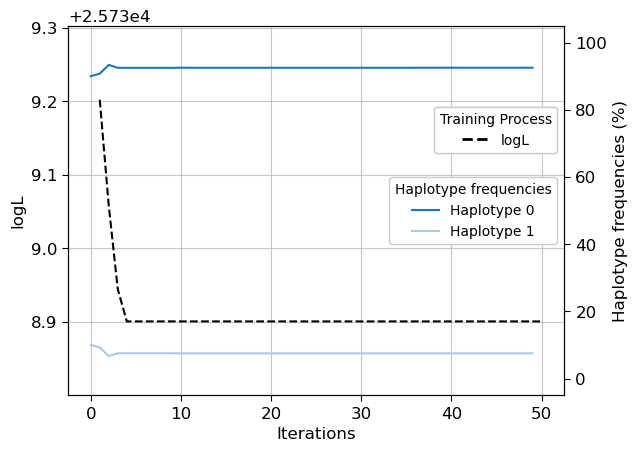

In [99]:
plot_training(results)

## GYP: DEL1 and DEL2

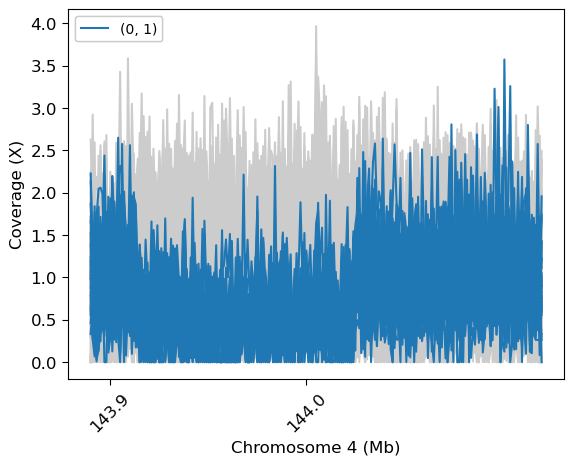

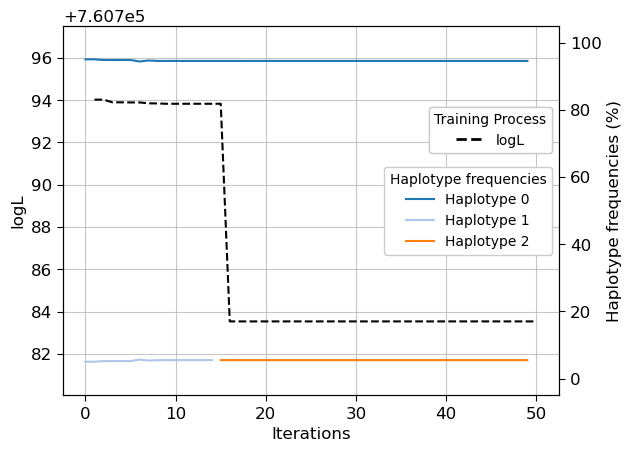

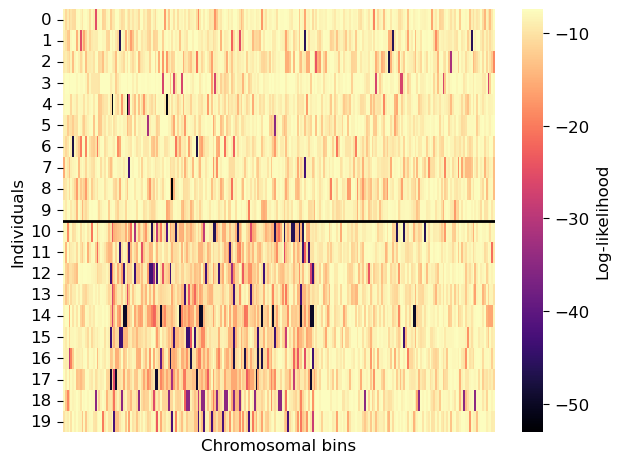

In [47]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000
chromosome = 4
start = 143890000
end = 144120000
flank = end - start

cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore(means, variances, coverage, n_iter = 50)

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results)
plt.show()
plot_sv_heatmap(means, variances, coverage, samples, results)

## DUP1

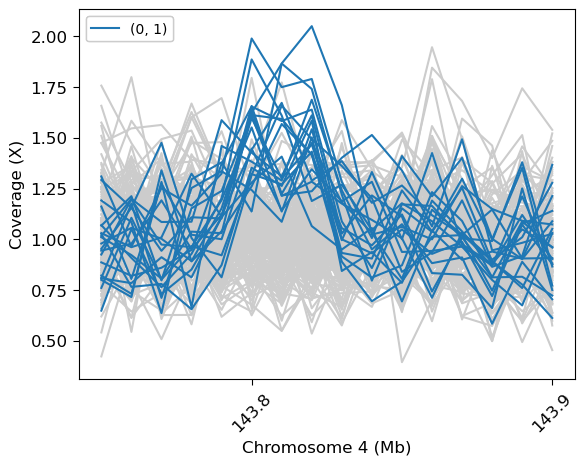

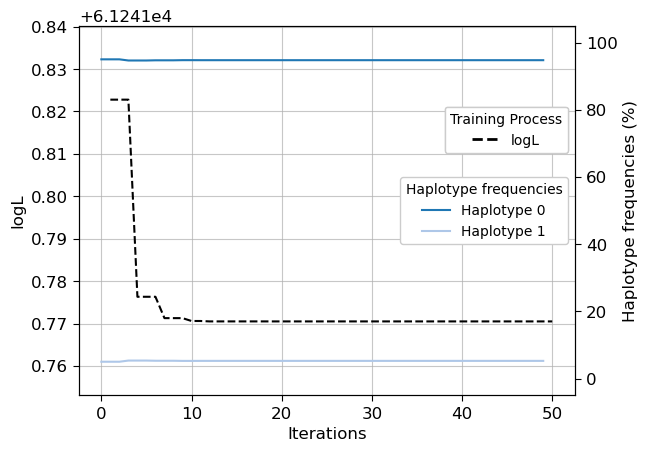

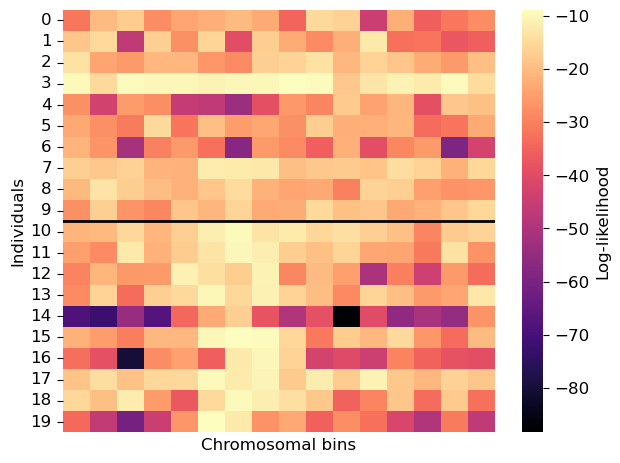

In [2]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000
chromosome = 4
start = 143780000
end = 143850000
flank = end - start

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]

bin_size = 10000
chromosome = 4
start = 143750000
end = 143900000
flank = end - start
cov1 = deresolute_windows(cov, bin_size, normalise = False)
cov = cov1.copy()

means, variances = normalise_by_flank(cov, start, end, flank, side = 'left')
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore(means, variances, coverage, samples, n_iter = 50)

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results)
plt.show()
plot_sv_heatmap(means, variances, coverage, results)

In [6]:
best_model = results['model_ary'][-1]
L, N = coverage.shape
pre_computed_lls = precompute_site_lls(means, variances, coverage)
geom_penalty = 0.5

lls, _ , model_ll = multi_evaluate_model(best_model, N, pre_computed_lls, geom_penalty)

In [ ]:
# DEL1,2
start = 143890000
end = 144120000
flank = end - start
cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means_del1, variances_del1 = normalise_by_flank(cov, start, end, flank)
print(variances_del1.mean()/(end-start)) ### 1.33

# DUP1
start = 143780000
end = 143850000
flank = end - start
cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means_dup1, variances_dup1 = normalise_by_flank(cov, start, end, flank)
print(variances_dup1.mean()/(end-start)) ### 4.39

## HBA

------ Iteration 5 ------
Best loglikelihood: 101350.85845383795
------ Iteration 10 ------
Best loglikelihood: 100994.10565414575
------ Iteration 15 ------
Best loglikelihood: 100940.6353211489
------ Iteration 20 ------
Best loglikelihood: 100940.6353211489
------ Iteration 25 ------
Best loglikelihood: 100940.39614598446
------ Iteration 30 ------
Best loglikelihood: 100940.39614598446
------ Iteration 35 ------
Best loglikelihood: 100939.93094761952
------ Iteration 40 ------
Best loglikelihood: 100939.93094761952
------ Iteration 45 ------
Best loglikelihood: 100939.93094761952
------ Iteration 50 ------
Best loglikelihood: 100939.93094761952
------ Iteration 55 ------
Best loglikelihood: 100939.84698074592
------ Iteration 60 ------
Best loglikelihood: 100939.84698074592
------ Iteration 65 ------
Best loglikelihood: 100939.84698074592
------ Iteration 70 ------
Best loglikelihood: 100939.84698074592
------ Iteration 75 ------
Best loglikelihood: 100939.84698074592
------ Iterat

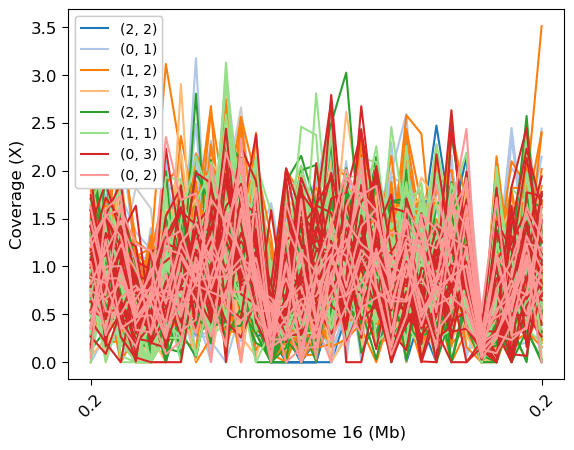

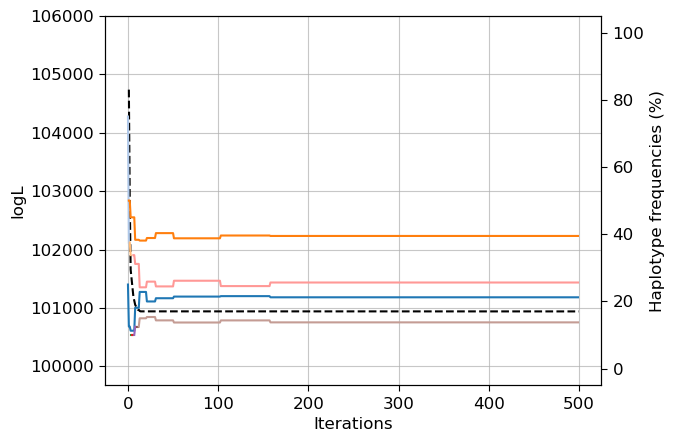

In [12]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000
chromosome = 16
start = 160000
end = 190000
flank = end - start

cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results, show_legends = False)
plt.show()
# plot_sv_heatmap(means, variances, coverage, samples, results)

In [14]:
best_model.freqs

[0.2119997307484103,
 0.39458260229761477,
 0.25602289522211186,
 0.13739477173186315]

------ Iteration 5 ------
Best loglikelihood: 72000.46881464103
------ Iteration 10 ------
Best loglikelihood: 71997.95910983323
------ Iteration 15 ------
Best loglikelihood: 71997.95910983323
------ Iteration 20 ------
Best loglikelihood: 71997.95910983323
------ Iteration 25 ------
Best loglikelihood: 71997.95910983323
------ Iteration 30 ------
Best loglikelihood: 71997.39152833034
------ Iteration 35 ------
Best loglikelihood: 71997.34825042705
------ Iteration 40 ------
Best loglikelihood: 71997.34825042705
------ Iteration 45 ------
Best loglikelihood: 71997.34825042705
------ Iteration 50 ------
Best loglikelihood: 71997.34825042705
------ Iteration 55 ------
Best loglikelihood: 71997.32907647727
------ Iteration 60 ------
Best loglikelihood: 71997.07849313229
------ Iteration 65 ------
Best loglikelihood: 71997.07849313229
------ Iteration 70 ------
Best loglikelihood: 71997.07849313229
------ Iteration 75 ------
Best loglikelihood: 71997.07849313229
------ Iteration 80 ------

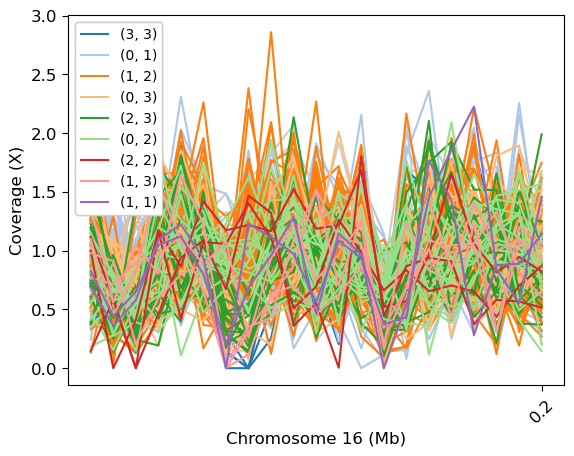

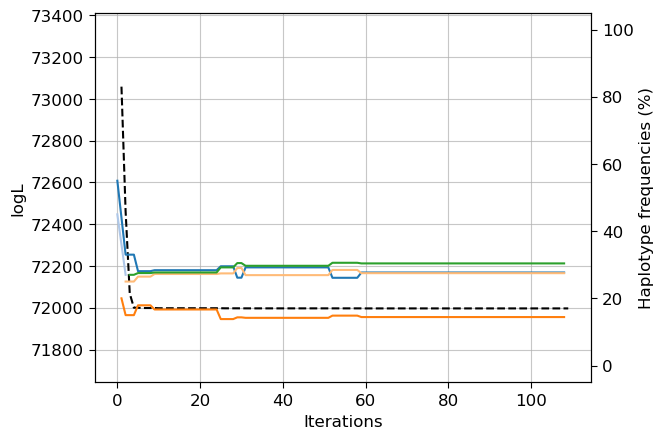

In [7]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 2000
chromosome = 16
start = 160000
end = 200000
flank = end - start

cov = pd.read_csv('results/coverage/specific_regions/HBA.tsv', sep = '\t')
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore(means, variances, coverage, samples, 
                   n_recomb = 2000, n_iter = 500, bin_size = bin_size, verbose = True)

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results, show_legends = False)
plt.show()
# plot_sv_heatmap(means, variances, coverage, samples, results)

In [8]:
best_model.haps

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1.]),
 array([1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1.])]